# Important libraries

In [1]:
import win32com.client
import sys
import time
import os
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
import pandas as pd
import math
import matplotlib.pyplot as plt

# Openserver Setup

Openserver class with methods to connect to the server, send commands, and disconnect from the server.

In [2]:
class OpenServer():
    "Class for holding ActiveX reference. Allows license disconnectio"
    def __init__(self):
        self.status = "Disconnected"
        self.OSReference = None
    
    def Connect(self):
        self.OSReference = win32com.client.Dispatch("PX32.OpenServer.1")
        self.status = "Connected"
        print("OpenServer connected")
        
    def Disconnect(self):
        self.OSReference = None
        self.status = "Disconnected"
        print("OpenServer disconnected")

In [3]:
def GetAppName(sv):
    # function for returning app name from tag string
    pos = sv.find(".")
    if pos < 2:
        sys.exit("GetAppName: Badly formed tag string")
    app_name = sv[:pos]
    if app_name.lower() not in ["prosper", "mbal", "gap", "pvt", "resolve",
                                   "reveal"]:
        sys.exit("GetAppName: Unrecognised application name in tag string")
    return app_name


def DoCmd(OpenServe, cmd):
    # perform a command and check for errors
    lerr = OpenServe.OSReference.DoCommand(cmd)
    if lerr > 0:
        err = OpenServe.OSReference.GetErrorDescription(lerr)
        OpenServe.Disconnect()
        sys.exit("DoCmd: " + err)


def DoSet(OpenServe, sv, val):
    # set a value and check for errors
    lerr = OpenServe.OSReference.SetValue(sv, val)
    app_name = GetAppName(sv)
    lerr = OpenServe.OSReference.GetLastError(app_name)
    if lerr > 0:
        err = OpenServe.OSReference.GetErrorDescription(lerr)
        OpenServe.Disconnect()
        sys.exit("DoSet: " + err)
    
def DoGet(OpenServe, gv):
    # get a value and check for errors
    get_value = OpenServe.OSReference.GetValue(gv)
    app_name = GetAppName(gv)
    lerr = OpenServe.OSReference.GetLastError(app_name)
    if lerr > 0:
        err = OpenServe.OSReference.GetErrorDescription(lerr)
        OpenServe.Disconnect()
        sys.exit("DoGet: " + err)
    return get_value


def DoSlowCmd(OpenServe, cmd):
    # perform a command then wait for command to exit and check for errors
    step = 0.001
    app_name = GetAppName(cmd)
    lerr = OpenServe.OSReference.DoCommandAsync(cmd)
    if lerr > 0:
        err = OpenServe.OSReference.GetErrorDescription(lerr)
        OpenServe.Disconnect()
        sys.exit("DoSlowCmd: " + err)
    while OpenServe.OSReference.IsBusy(app_name) > 0:
        if step < 2:
            step = step*2
        time.sleep(step)
    lerr = OpenServe.OSReference.GetLastError(app_name)
    if lerr > 0:
        err = OpenServe.OSReference.GetErrorDescription(lerr)
        OpenServe.Disconnect()
        sys.exit("DoSlowCmd: " + err)


def DoGAPFunc(OpenServe, gv):
    DoSlowCmd(gv)
    DoGAPFunc = DoGet(OpenServe, "GAP.LASTCMDRET")
    lerr = OpenServe.OSReference.GetLastError("GAP")
    if lerr > 0:
        err = OpenServe.OSReference.GetErrorDescription(lerr)
        OpenServe.Disconnect()
        sys.exit("DoGAPFunc: " + err)
    return DoGAPFunc


def OSOpenFile(OpenServe, theModel, appname):
    DoSlowCmd(OpenServe, appname + '.OPENFILE ("' + theModel + '")')
    lerr = OpenServe.OSReference.GetLastError(appname)
    if lerr > 0:
        err = OpenServe.OSReference.GetErrorDescription(lerr)
        OpenServe.Disconnect()
        sys.exit("OSOpenFile: " + err)


def OSSaveFile(OpenServe, theModel, appname):
    DoSlowCmd(OpenServe, appname + '.SAVEFILE ("' + theModel + '")')
    lerr = OpenServe.OSReference.GetLastError(appname)
    if lerr > 0:
        err = OpenServe.OSReference.GetErrorDescription(lerr)
        OpenServe.Disconnect()
        sys.exit("OSSaveFile: " + err)

# Multiple well calculation

In [4]:
#gas availability and increment steps
number_of_wells = int(input('Please enter the number of wells:'))
gas_available = float(input('Please enter available gas'))
increment = float(input('Please enter the increment value'))
gas_injection_array = np.arange(0, gas_available + increment, increment)
df=pd.DataFrame()
df['gas_injection_array'] = gas_injection_array
df

,gas_injection_array
0,0.00
1,0.05
2,0.10
3,0.15
4,0.20
...,...
66,3.30
67,3.35
68,3.40
69,3.45


In [5]:
os.chdir(r'C:\Users\Mehdi\Desktop\Desktop2\Desktop1\Data Science\Projects\KL project\GAS LIFT OPTIMIZATION')

FileNotFoundError: [WinError 3] The system cannot find the path specified: 'C:\\Users\\Mehdi\\Desktop\\Desktop2\\Desktop1\\Data Science\\Projects\\KL project\\GAS LIFT OPTIMIZATION'

In [ ]:
# Initialises an 'OpenServer' class

petex = OpenServer()

# Creates ActiveX reference and holds a license

petex.Connect()
oil_rates_for_wells = {}

# Perform functions

cwd = os.getcwd()
for j in range(1,number_of_wells+1):
    #opening well file
    OSOpenFile(petex, cwd + f'\models\well_{j}.Out', 'PROSPER')
    print(f'Well {j} opened')
    #oil rates calculation
    for i in range(0,len(gas_injection_array)):
        command = f'PROSPER.ANL.SYS.Sens.SensDB.Sens[138].Vals[{i}]'
        DoSet(petex, command,gas_injection_array[i])
    DoCmd(petex, 'PROSPER.ANL.SYS.CALC')
    oil_rates = [] #list of oil rates for 1 well
    for i in range(0, len(gas_injection_array)):
        value = f'PROSPER.OUT.SYS.Results[{i}].Sol.OilRate'
        oil_rates.append(np.round(float(DoGet(petex, value)),2))
    oil_rates_for_wells[f'well_{j}'] = oil_rates
    #closing file   
    OSSaveFile(petex, cwd + f'\well_{j}.Out', 'PROSPER')
    print(f'Well {j} closed')

#merging to main dataframe
for i in range(1,number_of_wells+1):
    df[f'Well_{i}'] = oil_rates_for_wells[f'well_{i}']

df.head()

OpenServer connected
Well 1 opened
Well 1 closed
Well 2 opened
Well 2 closed
Well 3 opened
Well 3 closed
Well 4 opened
Well 4 closed
Well 5 opened
Well 5 closed
Well 6 opened
Well 6 closed
Well 7 opened
Well 7 closed
Well 8 opened
Well 8 closed
Well 9 opened
Well 9 closed
Well 10 opened
Well 10 closed


,gas_injection_array,Well_1,Well_2,Well_3,Well_4,Well_5,Well_6,Well_7,Well_8,Well_9,Well_10
0,0.00,878.37,1657.35,1576.44,1362.42,997.05,1858.40,1767.62,1123.93,1717.52,1749.18
1,0.05,887.66,1663.12,1582.52,1369.43,1005.79,1863.00,1772.88,1132.25,1723.02,1754.56
2,0.10,896.05,1668.40,1588.09,1375.90,1013.68,1867.23,1777.72,1139.83,1728.00,1759.44
3,0.15,904.96,1673.25,1593.20,1381.88,1020.93,1871.12,1782.06,1146.76,1734.79,1763.88
4,0.20,911.90,1677.71,1597.90,1387.41,1027.60,1874.69,1786.06,1153.42,1739.01,1767.97


In [ ]:
#sensisitivity plot if all wells receive equal amount of gas
fig = go.Figure()
for i in range(1,number_of_wells+1):
    
    fig.add_trace(go.Scatter(x=df['gas_injection_array'], y=df[f'Well_{i}'],
                            mode='lines', name=f'Well_{i}'))
fig.update_layout(title='Sensitivity Plot(all wells receive equal amount of gas lift)',
                   xaxis_title='Gaslift Gas Injection Rate(MMscf/day)',
                   yaxis_title='Oil Rate(STB/day)',
                   title_x=0.5, 
                   )
fig.update_xaxes(nticks=50)
fig.update_yaxes(nticks=20)
fig.show()

In [ ]:
#extracting max gas lift oil rate pairs
df_new = df.drop('gas_injection_array', axis=1)
wells = []
i=1
for element in df_new.idxmax():
    oil_rate = df_new[f'Well_{i}'][element]
    gas_lift = df['gas_injection_array'][element]
    wells.append({'production_rate':oil_rate, 'gas_lift':gas_lift})
    i+=1
wells

[{'production_rate': 985.32, 'gas_lift': 1.5},
 {'production_rate': 1717.55, 'gas_lift': 1.4000000000000001},
 {'production_rate': 1643.5, 'gas_lift': 1.5},
 {'production_rate': 1447.71, 'gas_lift': 1.5},
 {'production_rate': 1101.44, 'gas_lift': 1.5},
 {'production_rate': 1904.17, 'gas_lift': 1.2000000000000002},
 {'production_rate': 1819.58, 'gas_lift': 1.25},
 {'production_rate': 1223.78, 'gas_lift': 1.5},
 {'production_rate': 1775.91, 'gas_lift': 1.3},
 {'production_rate': 1802.58, 'gas_lift': 1.3}]

In [ ]:
# wells = [{'production_rate': 987.44, 'gas_lift': 1.7},
#          {'production_rate': 1717.55, 'gas_lift': 1.4},
#          {'production_rate': 1643.5, 'gas_lift': 1.5},
#          {'production_rate': 1448.2, 'gas_lift': 1.7},
#          {'production_rate': 1104.21, 'gas_lift': 1.9},
#          {'production_rate': 1904.17, 'gas_lift': 1.2},
#          {'production_rate': 1819.56, 'gas_lift': 1.3},
#          {'production_rate': 1225.93, 'gas_lift': 1.9},
#          {'production_rate': 1775.91, 'gas_lift': 1.3},
#          {'production_rate': 1802.58, 'gas_lift': 1.3}]
#copy and paste the values from above based on number of wells determineed
wells = [
 {'production_rate': 985.32, 'gas_lift': 1.5},
 {'production_rate': 1717.55, 'gas_lift': 1.4000000000000001},
 {'production_rate': 1643.5, 'gas_lift': 1.5},
 {'production_rate': 1447.71, 'gas_lift': 1.5},
 {'production_rate': 1101.44, 'gas_lift': 1.5},
 {'production_rate': 1904.17, 'gas_lift': 1.2000000000000002},
 {'production_rate': 1819.58, 'gas_lift': 1.25},
 {'production_rate': 1223.78, 'gas_lift': 1.5},
 {'production_rate': 1775.91, 'gas_lift': 1.3},
 {'production_rate': 1802.58, 'gas_lift': 1.3}]
well_list = [(d['production_rate'], d['gas_lift']) for d in wells]

# Ant Colony Algorithm(ACO)

# Current solution with ACO

In [ ]:
"""
import numpy as np

def optimize_gas_allocation(wells, gas_capacity, alpha, beta, evaporation_rate, iteration_count):
    """
    Optimizes the allocation of gas to a group of wells using an ant colony algorithm.

    Parameters:
    - wells: a list of dictionaries representing the wells, where each dictionary contains the following keys:
        - 'production_rate': the production rate of the well (in STB/day)
        - 'gas_lift': the gas lift of the well (in STB/day)
    - gas_capacity: the total gas capacity available for allocation (in STB/day)
    - alpha: the weight of the pheromone trail in the decision making process
    - beta: the weight of the heuristic value in the decision making process
    - evaporation_rate: the rate at which the pheromone trails evaporate
    - iteration_count: the number of iterations to run the algorithm for

    Returns:
    - A list of dictionaries representing the optimized allocation of gas to the wells, where each dictionary contains the following keys:
        - 'well_id': the ID of the well
        - 'allocation': the optimized allocation of gas to the well (in STB/day)
    """
    # Initialize the pheromone trails and heuristic values for each well
    pheromone_trails = np.ones(len(wells))
    heuristic_values = np.array([well['production_rate'] / well['gas_lift'] for well in wells])

    # Run the algorithm for the specified number of iterations
    for i in range(iteration_count):
        # Initialize the allocation for each well
        allocations = np.zeros(len(wells))

        # Allocate gas to each well using the ant colony algorithm
        remaining_gas = gas_capacity
        for j, well in enumerate(wells):
            # Calculate the allocation probability for the well
            allocation_probability = (pheromone_trails[j] ** alpha) * (heuristic_values[j] ** beta)
            allocation_probability /= np.sum((pheromone_trails ** alpha) * (heuristic_values ** beta))

            # Allocate gas to the well based on the allocation probability
            # allocation = min(well['gas_lift'], remaining_gas * allocation_probability)
            allocation = min(remaining_gas, remaining_gas * allocation_probability)
            allocations[j] = allocation
            remaining_gas -= allocation

        # Evaporate the pheromone trails based on the evaporation rate
        pheromone_trails *= (1 - evaporation_rate)

        # Update the pheromone trails based on the allocations
        for j, well in enumerate(wells):
            pheromone_trails[j] += allocations[j] / well['production_rate']

    # Return the optimized allocation of gas to the wells
    return [{'well_id': j, 'allocation': allocations[j]} for j in range(len(wells))]
"""

# Testing the current solution

In [ ]:
"""
gas_capacity = 5 #total available gas
#best solution parameters
alpha = 0.05
beta = 2
evaporation_rate = 0.7
iteration_count = 150

# Optimize the allocation of gas to the wells
allocations = optimize_gas_allocation(wells, gas_capacity, alpha, beta, evaporation_rate, iteration_count)

# Print the optimized allocation
print(allocations)
"""

[{'well_id': 0, 'allocation': 0.5282946214482023}, {'well_id': 1, 'allocation': 1.6993124643504554}, {'well_id': 2, 'allocation': 0.8116342664200924}, {'well_id': 3, 'allocation': 0.434446884591163}]


In [ ]:
"""
#total gas consumed
sum_gas = 0
for alloc in allocations:
    sum_gas+=alloc['allocation']
print(sum_gas)
"""

3.473688236809913


# Visualize the current solution

In [ ]:
"""
gas_dict = {}
for i in range(len(allocations)):
    gas_available = allocations[i]['allocation']
    increment = increment
    gas_injection_array = np.arange(0, gas_available, increment)
    gas_dict[f'gas_injection_array_{i+1}'] = gas_injection_array
gas_dict
"""

{'gas_injection_array_1': array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ]),
 'gas_injection_array_2': array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
        0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  , 1.05,
        1.1 , 1.15, 1.2 , 1.25, 1.3 , 1.35, 1.4 , 1.45, 1.5 , 1.55, 1.6 ,
        1.65]),
 'gas_injection_array_3': array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
        0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 ]),
 'gas_injection_array_4': array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 ])}

In [ ]:
"""
# Initialises an 'OpenServer' class
petex = OpenServer()

petex.Connect()
oil_rates_for_wells = {}

# Perform functions
cwd = os.getcwd()

for j in range(len(gas_dict)):
#opening well file
    OSOpenFile(petex, cwd + f'\models\well_{j+1}.Out', 'PROSPER')
    print(f'Well {j+1} opened')

    for i in range(0,len(gas_dict[f'gas_injection_array_{j+1}'])):
            command = f'PROSPER.ANL.SYS.Sens.SensDB.Sens[138].Vals[{i}]'
            DoSet(petex, command,gas_dict[f'gas_injection_array_{j+1}'][i])

    DoCmd(petex, 'PROSPER.ANL.SYS.CALC')
    oil_rates = [] #list of oil rates for 1 well
    for i in range(0, len(gas_dict[f'gas_injection_array_{j+1}'])):
            value = f'PROSPER.OUT.SYS.Results[{i}].Sol.OilRate'
            oil_rates.append(np.round(float(DoGet(petex, value)),2))
    oil_rates_for_wells[f'well_{j+1}'] = oil_rates

    OSSaveFile(petex, cwd + f'\well_{j+1}.Out', 'PROSPER')
    print(f'Well {j+1} closed')

oil_rates_for_wells

"""

OpenServer connected
Well 1 opened
Well 1 closed
Well 2 opened
Well 2 closed
Well 3 opened
Well 3 closed
Well 4 opened
Well 4 closed


{'well_1': [878.37,
  887.66,
  896.05,
  904.96,
  911.9,
  918.29,
  924.19,
  930.24,
  935.19,
  939.81,
  944.14],
 'well_2': [1657.35,
  1663.12,
  1668.4,
  1673.25,
  1677.71,
  1681.81,
  1685.58,
  1689.05,
  1692.24,
  1695.17,
  1697.85,
  1700.31,
  1702.57,
  1705.03,
  1706.89,
  1708.57,
  1710.09,
  1711.42,
  1712.6,
  1713.64,
  1714.54,
  1715.32,
  1715.98,
  1716.53,
  1716.94,
  1717.24,
  1717.44,
  1717.54,
  1717.55,
  1717.47,
  1717.3,
  1717.04,
  1716.69,
  1716.26],
 'well_3': [1576.44,
  1582.52,
  1588.09,
  1593.2,
  1597.9,
  1602.23,
  1606.21,
  1609.91,
  1613.28,
  1616.38,
  1619.15,
  1621.64,
  1623.94,
  1628.5,
  1630.42,
  1632.19,
  1633.8],
 'well_4': [1362.42,
  1369.43,
  1375.9,
  1381.88,
  1387.41,
  1392.53,
  1397.28,
  1401.69,
  1405.79]}

In [ ]:
"""
fig = go.Figure()
for i in range(1,number_of_wells+1):

    fig.add_trace(go.Scatter(x=gas_dict[f'gas_injection_array_{i}'], y=oil_rates_for_wells[f'well_{i}'],
                            mode='lines', name=f'Well_{i}'))
fig.update_layout(title='Sensitivity Plot with ACO algorithm',
                   xaxis_title='Gaslift Gas Injection Rate(MMscf/day)',
                   yaxis_title='Oil Rate(STB/day)',
                   title_x=0.5,
                   )
fig.update_xaxes(nticks=50)
fig.update_yaxes(nticks=20)
fig.show()

"""

"\nfig = go.Figure()\nfor i in range(1,number_of_wells+1):\n\n    fig.add_trace(go.Scatter(x=gas_dict[f'gas_injection_array_{i}'], y=oil_rates_for_wells[f'well_{i}'],\n                            mode='lines', name=f'Well_{i}'))\nfig.update_layout(title='Sensitivity Plot with ACO algorithm',\n                   xaxis_title='Gaslift Gas Injection Rate(MMscf/day)',\n                   yaxis_title='Oil Rate(STB/day)',\n                   title_x=0.5,\n                   )\nfig.update_xaxes(nticks=50)\nfig.update_yaxes(nticks=20)\nfig.show()\n\n"

# Particle Swarm Optimization (PSO)

# Current solution with PSO

In [ ]:
import numpy as np
import random

def optimize_gas_allocation_PSO(wells, gas_capacity, iteration_count, num_particles):
    # Initialize the particles and their velocities
    particles = [np.random.rand(len(wells)) for _ in range(num_particles)]
    velocities = [np.zeros(len(wells)) for _ in range(num_particles)]

    # Initialize the best position and best fitness for each particle
    personal_best_positions = particles.copy()
    personal_best_fitness = [np.inf for _ in range(num_particles)]

    # Initialize the global best position and global best fitness
    global_best_position = personal_best_positions[np.argmin(personal_best_fitness)]
    global_best_fitness = np.inf

    # Run the algorithm for the specified number of iterations
    for i in range(iteration_count):
        # Update the position and fitness of each particle
        for j, particle in enumerate(particles):
            # Update the velocity of the particle
            rp = random.uniform(0,1)
            rg = random.uniform(0,1)
            velocities[j] = 0.5 * velocities[j] + rp * (personal_best_positions[j] - particle) + rg * (global_best_position - particle)
            # Update the position of the particle
            particles[j] += velocities[j]
            # Ensure that the particle's position is within the constraints
            particles[j] = np.maximum(np.zeros(len(wells)), particles[j])

            # Calculate the fitness of the particle
            fitness = -1 * np.sum(particles[j] * [well['production_rate'] for well in wells])
            # Update the personal best position and personal best fitness of the particle
            if fitness < personal_best_fitness[j]:
                personal_best_positions[j] = particles[j]
                personal_best_fitness[j] = fitness

            # Check if the total gas allocated to all wells is less than or equal to the total available gas capacity
            total_gas_allocated = sum(particles[j])
            if total_gas_allocated > gas_capacity:
                particles[j] = particles[j] * (gas_capacity / total_gas_allocated)
                total_gas_allocated = gas_capacity

            # Update the global best position and global best fitness
            if fitness < global_best_fitness:
                global_best_position = particles[j]
                global_best_fitness = fitness
    return [{'well_id': j, 'allocation': global_best_position[j]} for j in range(len(wells))]


# Testing the current solution

In [ ]:
gas_capacity= 1.5
iteration_count= 50
num_part = 240
allocations = optimize_gas_allocation_PSO(wells, gas_capacity, iteration_count, num_part)
allocations

[{'well_id': 0, 'allocation': 0.15638891026140722},
 {'well_id': 1, 'allocation': 0.09899043146276852},
 {'well_id': 2, 'allocation': 0.1405810959281357},
 {'well_id': 3, 'allocation': 0.16146644862585288},
 {'well_id': 4, 'allocation': 0.1625768972919959},
 {'well_id': 5, 'allocation': 0.15172500386610369},
 {'well_id': 6, 'allocation': 0.14869523320318948},
 {'well_id': 7, 'allocation': 0.1482012424186801},
 {'well_id': 8, 'allocation': 0.1800123363048387},
 {'well_id': 9, 'allocation': 0.15136240063702777}]

In [ ]:
#total gas consumed
sum_gas = 0
for alloc in allocations:
    sum_gas+=alloc['allocation']
print(sum_gas)

1.5


In [ ]:
# test the accuracy of method-Matt
petex = OpenServer()

petex.Connect()
oil_rates = []

# Perform functions
cwd = os.getcwd()

for j in range(len(allocations)):
#opening well file
    OSOpenFile(petex, cwd + f'\models\well_{j+1}.Out', 'PROSPER')
    print(f'Well {j+1} opened')

    DoSet(petex,'PROSPER.ANL.SYS.Sens.SensDB.Clear',0)
    DoSet(petex,"PROSPER.ANL.SYS.Sens.SensDB.Vars[0]",22)
    
    DoSet(petex,"PROSPER.ANL.SYS.Sens.SensDB.Sens[138].Vals["+str(0)+"]",allocations[j]['allocation'])

    DoCmd(petex, 'PROSPER.ANL.SYS.CALC')
     
    
    oil_rates.append((np.round(float(DoGet(petex, 'PROSPER.OUT.SYS.Results[0].Sol.OilRate')),2),allocations[j]['allocation']))
    

petex.Disconnect()

oil_rates

OpenServer connected
Well 1 opened
Well 2 opened
Well 3 opened
Well 4 opened
Well 5 opened
Well 6 opened
Well 7 opened
Well 8 opened
Well 9 opened
Well 10 opened
OpenServer disconnected


[(905.88, 0.15638891026140722),
 (1668.3, 0.09899043146276852),
 (1592.27, 0.1405810959281357),
 (1383.18, 0.16146644862585288),
 (1022.66, 0.1625768972919959),
 (1871.24, 0.15172500386610369),
 (1781.95, 0.14869523320318948),
 (1146.52, 0.1482012424186801),
 (1737.36, 0.1800123363048387),
 (1764.0, 0.15136240063702777)]

In [ ]:
sum([x[0] for x in oil_rates]),sum([x[1] for x in oil_rates])

(14873.360000000002, 1.5)

# Visualize the current solution

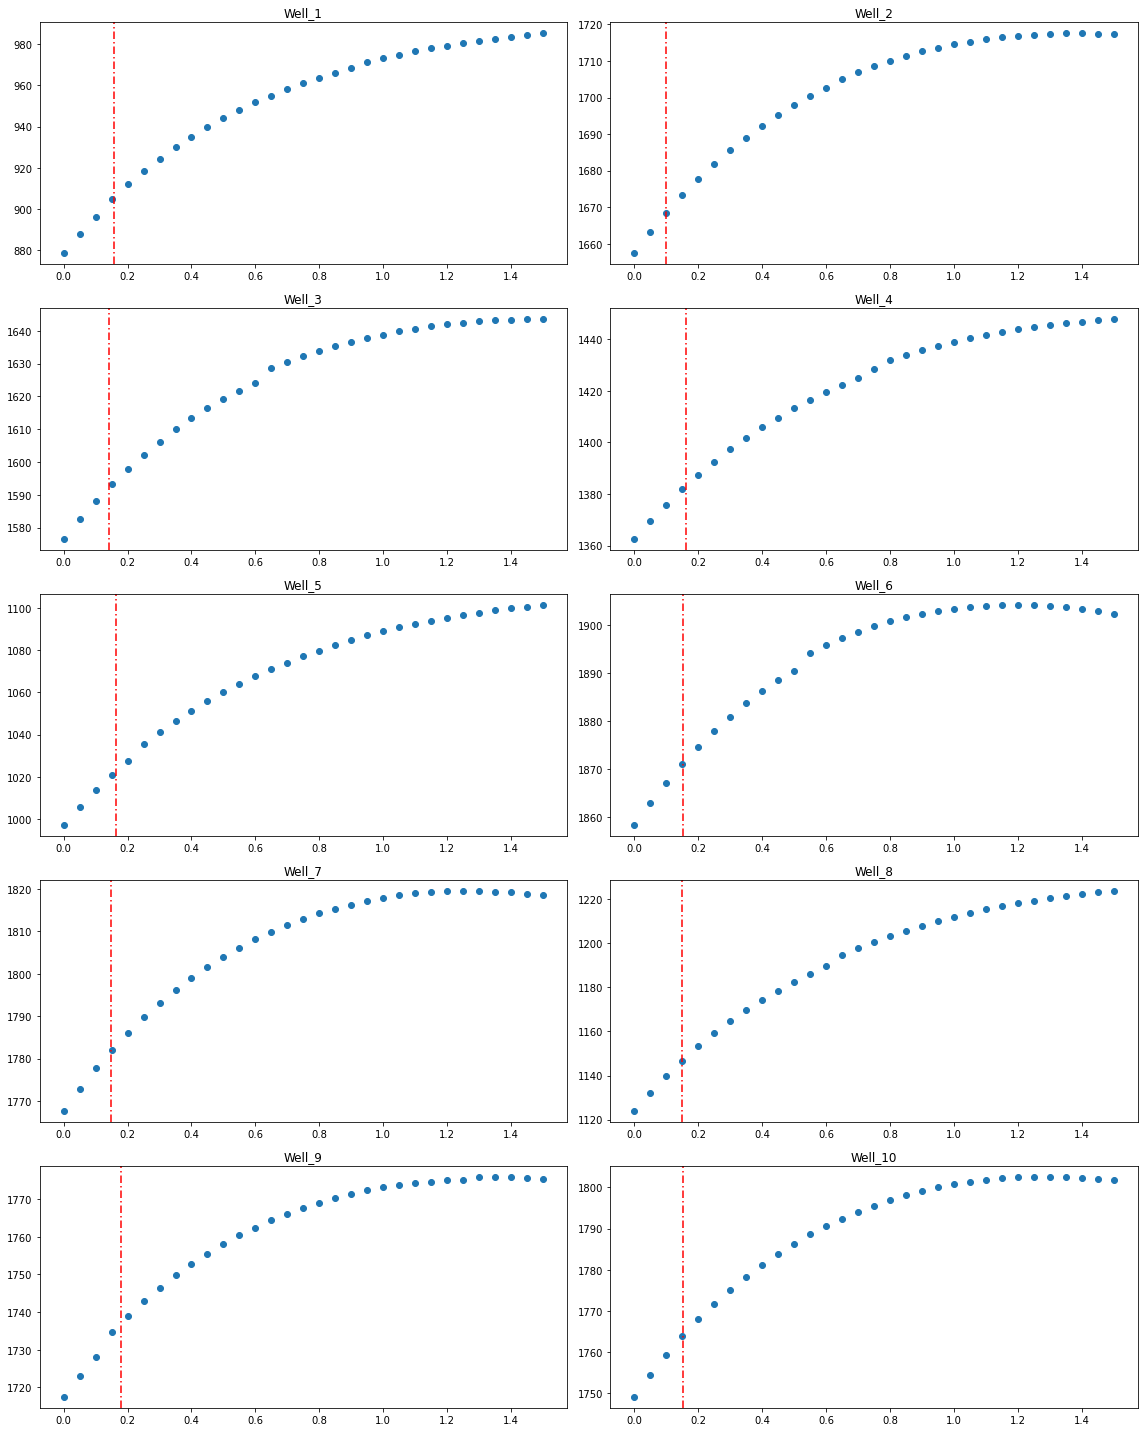

In [ ]:
cols = 2
rows = math.ceil(len(allocations)/cols)
fig, axs = plt.subplots(nrows = rows, ncols = cols, figsize=(16,20))

for i in range(number_of_wells):
    k = i//2
    j = i%2
    
    x=df['gas_injection_array'] 
    y=df[f'Well_{i+1}']
    label=f'Well_{i+1}' 
    
    axs[k,j].plot(x,y,'o')
    axs[k,j].set_title(label)
    axs[k,j].axvline(oil_rates[i][1],c='r', dashes=(5,2,1,2))
    
    fig.tight_layout()
plt.show()

In [ ]:
"""
gas_dict = {}
for i in range(len(allocations)):
    gas_available = allocations[i]['allocation']
    increment = increment
    gas_injection_array = np.arange(0, gas_available, increment)
    gas_dict[f'gas_injection_array_{i+1}'] = gas_injection_array
gas_dict
"""

In [ ]:
"""
# Initialises an 'OpenServer' class
petex = OpenServer()

petex.Connect()
oil_rates_for_wells = {}

# Perform functions
cwd = os.getcwd()

for j in range(len(gas_dict)):
#opening well file
    OSOpenFile(petex, cwd + f'\models\well_{j+1}.Out', 'PROSPER')
    print(f'Well {j+1} opened')

    for i in range(0,len(gas_dict[f'gas_injection_array_{j+1}'])):
            command = f'PROSPER.ANL.SYS.Sens.SensDB.Sens[138].Vals[{i}]'
            DoSet(petex, command,gas_dict[f'gas_injection_array_{j+1}'][i])

    DoCmd(petex, 'PROSPER.ANL.SYS.CALC')
    oil_rates = [] #list of oil rates for 1 well
    for i in range(0, len(gas_dict[f'gas_injection_array_{j+1}'])):
            value = f'PROSPER.OUT.SYS.Results[{i}].Sol.OilRate'
            oil_rates.append(np.round(float(DoGet(petex, value)),2))
    oil_rates_for_wells[f'well_{j+1}'] = oil_rates

    OSSaveFile(petex, cwd + f'\well_{j+1}.Out', 'PROSPER')
    print(f'Well {j+1} closed')

oil_rates_for_wells
"""

In [ ]:
"""
fig = go.Figure()
for i in range(1,number_of_wells+1):

    fig.add_trace(go.Scatter(x=gas_dict[f'gas_injection_array_{i}'], y=oil_rates_for_wells[f'well_{i}'],
                            mode='lines', name=f'Well_{i}'))
fig.update_layout(title='Sensitivity Plot with PSO algorithm',
                   xaxis_title='Gaslift Gas Injection Rate(MMscf/day)',
                   yaxis_title='Oil Rate(STB/day)',
                   title_x=0.5,
                   )
fig.update_xaxes(nticks=50)
fig.update_yaxes(nticks=20)
fig.show()
"""